In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengolib
import numpy as np
import pandas as pd
import random
import scipy as sp

import pytry

In [37]:
from sklearn.decomposition import PCA

class PatternInterpolationTrial(pytry.Trial):
    def params(self):
        self.param('number of neurons', n_neurons=2000),
        #self.param('number of training patterns', n_train_pattern=3)
        
    def evaluate(self, q):
        data = pd.read_csv("pinsoro-2017-06-20-145454904791-small.csv", low_memory=False)
        
        x = np.array(data.iloc[:,11:195]).astype(float)
        a = []
        for i in range(x.shape[1]):
            y = pd.Series(x[:,i])
            z = y.interpolate(limit_direction='both')
            a.append(z)
        a = pd.DataFrame(a)
        a = a.dropna()
        a = np.array(a).T

        dt = 0.001
        
        def extract_pattern(start, end):
            pattern = np.array(a[start:end,:]).astype(float)
            frames = np.array(data.iloc[start:end,9]).astype(int)

            good_indices = frames != -1
            frames = frames[good_indices]
            pattern = pattern[good_indices]

            fps = 30.0
            t_sample = (frames - frames[0])/fps

            t = np.arange(int(t_sample[-1]/dt))*dt

            result = []
            for i in range(pattern.shape[1]):       
                p = np.interp(t, t_sample, pattern[:,i])
                result.append(p)
            result = np.array(result).T

            return t, result


        t1, result1 = extract_pattern(374, 1790) #goaloriented
        t2, result2 = extract_pattern(2642, 3446) #goaloriented
        t3, result3 = extract_pattern(3867, 4637) #goaloriented
        t4, result4 = extract_pattern(5976, 7491) #goaloriented
        t5, result5 = extract_pattern(16968, 18323) #goaloriented
        t6, result6 = extract_pattern(18569, 19200) #goaloriented
        t7, result7 = extract_pattern(23672, 24737) #goaloriented 
        t8, result8 = extract_pattern(24966, 26142) #goaloriented
        t9, result9 = extract_pattern(26697, 26989) #goaloriented 
        t10, result10 = extract_pattern(27100, 27156) #goaloriented
        t11, result11 = extract_pattern(27212, 27983) #goaloriented
        t12, result12 = extract_pattern(27984, 30898) #goaloriented
        t13, result13 = extract_pattern(31201, 32875) #goaloriented
        t14, result14 = extract_pattern(32876, 35231) #goaloriented
        t15, result15 = extract_pattern(35232, 37106) #goaloriented
        t16, result16 = extract_pattern(37278, 37637) #goaloriented
        
        t17, result17 = extract_pattern(69, 373) #noplay
        t18, result18 = extract_pattern(1943, 2036) #noplay
        t19, result19 = extract_pattern(2195, 2344) #noplay
        t20, result20 = extract_pattern(4638, 4727) #noplay
        t21, result21 = extract_pattern(5162, 5396) #noplay
        t22, result22 = extract_pattern(7492, 7532) #noplay
        t23, result23 = extract_pattern(8257, 8350) #noplay
        t24, result24 = extract_pattern(9974, 10133) #noplay
        t25, result25 = extract_pattern(10523, 10592) #noplay
        t26, result26 = extract_pattern(10835, 11160) #noplay
        t27, result27 = extract_pattern(12128, 12369) #noplay
        t28, result28 = extract_pattern(13653, 13852) #noplay
        t29, result29 = extract_pattern(14210, 14272) #noplay
        t30, result30 = extract_pattern(14374, 14422) #noplay
        t31, result31 = extract_pattern(14485, 14648) #noplay
        t32, result32 = extract_pattern(14755, 14811) #noplay
        t33, result33 = extract_pattern(14973, 15459) #noplay
        t34, result34 = extract_pattern(18324, 18451) #noplay
        t35, result35 = extract_pattern(19201, 19262) #noplay
        t36, result36 = extract_pattern(24738, 24965) #noplay
        t37, result37 = extract_pattern(26143, 26696) #noplay
        t38, result38 = extract_pattern(26990, 27099) #noplay
        t39, result39 = extract_pattern(27157, 27211) #noplay
        t40, result40 = extract_pattern(30899, 30979) #noplay
        t41, result41 = extract_pattern(37107, 37277) #noplay
        t42, result42 = extract_pattern(37638, 38416) #noplay

        goal_list = [result1, result2, result3, result4, result5, result6, result7, result8, result9, 
                     result10, result11, result12, result13, result14, result15, result16]
        noplay_list = [result17, result18, result19, result20, result21, result22, result23, result24,
                      result25, result26, result27, result28, result29, result30, result31, result32,
                      result33, result34, result35, result36, result37, result38, result39, result40,
                      result41, result42]
        
        print(goal_list)
       
        random.shuffle(goal_list)
        print(goal_list[0])
        goal_train = goal_list[:11]
        goal_test = goal_list[11:]
        
        random.shuffle(noplay_list)
        noplay_train = noplay_list[:19]
        noplay_test = noplay_list[19:]
        
        train_all = np.vstack(goal_train+noplay_train)
        pca_model = PCA(n_components=1).fit(train_all)

        goal_patterns = {}
        i=0
        for gp in goal_train:
            goal_patterns[i] = pca_model.transform(gp)[:,0]
            i+=1

        noplay_patterns = {}
        i=0
        for npp in noplay_train:
            noplay_patterns[i] = pca_model.transform(npp)[:,0]
            i+=1

        goal_patterns = [(goal_patterns[key]) for key in goal_patterns.keys()]
        noplay_patterns = [(noplay_patterns[key]) for key in noplay_patterns.keys()] 

        theta = 1.0
        net = nengo.Network()
        with net:
            process = nengo.processes.WhiteSignal(period=100., high=1.0, y0=0)
            rw = nengolib.networks.RollingWindow(theta=theta, n_neurons=q.n_neurons, process=process, neuron_type=nengo.LIFRate(tau_rc=0.02, tau_ref=0.002, amplitude=1))
            
        s_window = int(theta/dt)
        s_pattern = min(len(goal_patterns[0]), len(goal_patterns[1]), len(goal_patterns[2]), len(goal_patterns[3]),
                       len(goal_patterns[4]), len(goal_patterns[5]), len(goal_patterns[6]), len(goal_patterns[7]),
                       len(goal_patterns[8]), len(goal_patterns[9]), len(goal_patterns[10]), len(noplay_patterns[0]), 
                       len(noplay_patterns[1]), len(noplay_patterns[2]), len(noplay_patterns[3]), len(noplay_patterns[4]),
                       len(noplay_patterns[5]), len(noplay_patterns[6]), len(noplay_patterns[7]), len(noplay_patterns[8]),
                       len(noplay_patterns[9]), len(noplay_patterns[10]), len(noplay_patterns[11]), len(noplay_patterns[12]),
                       len(noplay_patterns[13]), len(noplay_patterns[14]), len(noplay_patterns[15]), len(noplay_patterns[16]),
                       len(noplay_patterns[17]), len(noplay_patterns[18]))


        t_window = np.linspace(0, 1, s_window)
        inv_basis = rw.inverse_basis(t_window)

        eval_points=[]
        target = []
        for i in range(s_pattern):
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[0], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[1], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[2], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[3], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[4], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[5], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[6], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[7], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[8], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[9], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[10], i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[0], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[1], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[2], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[3], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[4], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[5], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[6], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[7], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[8], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[9], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[10], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[11], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[12], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[13], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[14], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[15], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[16], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[17], i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[18], i)[:s_window]))
            target.append([-1])

        eval_points = np.array(eval_points)
        
        with net:
            result = nengo.Node(None, size_in=1)
            nengo.Connection(rw.state, result,
                             eval_points=eval_points, scale_eval_points=True,
                             function=target, synapse=0.1)
            
        train_all =  np.hstack([goal_patterns[0], goal_patterns[1], goal_patterns[2], goal_patterns[3],
                               goal_patterns[4], noplay_patterns[0], noplay_patterns[1], noplay_patterns[2],
                               noplay_patterns[3], noplay_patterns[4]])
        presentation_time_test=30/len(train_all)
        
        model = nengo.Network()
        model.networks.append(net)
        with model:    
            stim = nengo.Node(nengo.processes.PresentInput(train_all, presentation_time=presentation_time_test))
            nengo.Connection(stim, rw.input, synapse=None)

            p_result = nengo.Probe(result)
            p_stim = nengo.Probe(stim)
        sim = nengo.Simulator(model)
        sim.run(30)

        plt.plot(sim.trange(), sim.data[p_stim], label='input')
        plt.plot(sim.trange(), sim.data[p_result], label='output')
        plt.legend(loc='best')

############ EXTRACT TEST PATTERNS ############ 
        goal_test_patterns = {}
        i=0
        for p in goal_test:
            goal_test_patterns[i] = pca_model.transform(p)[:,0]
            i+=1

        noplay_test_patterns = {}
        for p in noplay_test:
            noplay_test_patterns[i] = pca_model.transform(p)[:,0]
            i+=1

        patterns = {}
        patterns.update(goal_test_patterns)
        patterns.update(noplay_test_patterns)

        goal_test_patterns = [(goal_test_patterns[key]) for key in goal_test_patterns.keys()]
        noplay_test_patterns = [(noplay_test_patterns[key]) for key in noplay_test_patterns.keys()] 
        
        test_all =  np.hstack([goal_test_patterns[0], goal_test_patterns[1], goal_test_patterns[2], goal_test_patterns[3],
                               goal_test_patterns[4], noplay_test_patterns[0], noplay_test_patterns[1], noplay_test_patterns[2],
                               noplay_test_patterns[3], noplay_test_patterns[4], noplay_test_patterns[5], noplay_test_patterns[6]])
        presentation_time_test=30/len(test_all)
        
        model = nengo.Network()
        model.networks.append(net)
        with model:    
            stim = nengo.Node(nengo.processes.PresentInput(test_all, presentation_time=presentation_time_test))
            nengo.Connection(stim, rw.input, synapse=None)

            p_result = nengo.Probe(result)
            p_stim = nengo.Probe(stim)
        sim = nengo.Simulator(model)
        sim.run(30)
        
        
        ###################################################  
        
        gp1_len = int(len(goal_test_patterns[0])*presentation_time_test/dt)
        gp2_len = gp1_len+int(len(goal_test_patterns[1])*presentation_time_test/dt)
        gp3_len = gp2_len+int(len(goal_test_patterns[2])*presentation_time_test/dt)
        gp4_len = gp3_len+int(len(goal_test_patterns[3])*presentation_time_test/dt)
        gp5_len = gp4_len+int(len(goal_test_patterns[4])*presentation_time_test/dt)

        mean_gp1 = np.mean(sim.data[p_result][0:gp1_len])       
        mean_gp2 = np.mean(sim.data[p_result][gp1_len:gp2_len])
        mean_gp3 = np.mean(sim.data[p_result][gp2_len:gp3_len])
        mean_gp4 = np.mean(sim.data[p_result][gp3_len:gp4_len])
        mean_gp5 = np.mean(sim.data[p_result][gp4_len:gp5_len])
        
        npp1_len = gp5_len+int(len(noplay_test_patterns[0])*presentation_time_test/dt)
        npp2_len = npp1_len+int(len(noplay_test_patterns[1])*presentation_time_test/dt)
        npp3_len = npp2_len+int(len(noplay_test_patterns[2])*presentation_time_test/dt)
        npp4_len = npp3_len+int(len(noplay_test_patterns[3])*presentation_time_test/dt)
        npp5_len = npp4_len+int(len(noplay_test_patterns[4])*presentation_time_test/dt)
        npp6_len = npp5_len+int(len(noplay_test_patterns[5])*presentation_time_test/dt)
        npp7_len = npp6_len+int(len(noplay_test_patterns[6])*presentation_time_test/dt)
        
        mean_npp1 = np.mean(sim.data[p_result][gp5_len:npp1_len])       
        mean_npp2 = np.mean(sim.data[p_result][npp1_len:npp2_len])
        mean_npp3 = np.mean(sim.data[p_result][npp2_len:npp3_len])
        mean_npp4 = np.mean(sim.data[p_result][npp3_len:npp4_len])
        mean_npp5 = np.mean(sim.data[p_result][npp4_len:npp5_len])
        mean_npp6 = np.mean(sim.data[p_result][npp5_len:npp6_len])
        mean_npp7 = np.mean(sim.data[p_result][npp6_len:npp7_len])
        
        
################# TEST ON AIMLESS PATTERNS #################
        
        t43, result43 = extract_pattern(1791, 1942) 
        t44, result44 = extract_pattern(2037, 2194)
        t45, result45 = extract_pattern(2345, 2641)
        t46, result46 = extract_pattern(3447, 3866)
        t47, result47 = extract_pattern(4728, 5161)
        t48, result48 = extract_pattern(5397, 5975)
        t49, result49 = extract_pattern(7533, 8256)
        t50, result50 = extract_pattern(8351, 9973)
        t51, result51 = extract_pattern(10134, 10522)
        t52, result52 = extract_pattern(10593, 10834)
        t53, result53 = extract_pattern(11161, 12127)

        testp1 = pca_model.transform(result43)[:,0]
        testp2 = pca_model.transform(result44)[:,0]
        testp3 = pca_model.transform(result45)[:,0]
        testp4 = pca_model.transform(result46)[:,0]
        testp5 = pca_model.transform(result47)[:,0]
        testp6 = pca_model.transform(result48)[:,0]
        testp7 = pca_model.transform(result49)[:,0]
        testp8 = pca_model.transform(result50)[:,0]
        testp9 = pca_model.transform(result51)[:,0]
        testp10 = pca_model.transform(result52)[:,0]
        testp11 = pca_model.transform(result53)[:,0]
               
        p_all = np.hstack([testp1, testp2, testp3, testp4, testp5, testp6,
                          testp7, testp8, testp9, testp10, testp11])

        presentation_time_test=30/len(p_all)

        model = nengo.Network()
        model.networks.append(net)
        with model:    
            stim = nengo.Node(nengo.processes.PresentInput(p_all, presentation_time=presentation_time_test))
            nengo.Connection(stim, rw.input, synapse=None)

            p_result = nengo.Probe(result)
            p_stim = nengo.Probe(stim)
        sim = nengo.Simulator(model)
        sim.run(30)

        aim1_len = int(len(testp1)*presentation_time_test/dt)
        aim2_len = aim1_len+int(len(testp2)*presentation_time_test/dt)
        aim3_len = aim2_len+int(len(testp3)*presentation_time_test/dt)
        aim4_len = aim3_len+int(len(testp4)*presentation_time_test/dt)
        aim5_len = aim4_len+int(len(testp5)*presentation_time_test/dt)
        aim6_len = aim5_len+int(len(testp6)*presentation_time_test/dt)
        aim7_len = aim6_len+int(len(testp7)*presentation_time_test/dt)
        aim8_len = aim7_len+int(len(testp8)*presentation_time_test/dt)
        aim9_len = aim8_len+int(len(testp9)*presentation_time_test/dt)
        aim10_len = aim9_len+int(len(testp10)*presentation_time_test/dt)
        aim11_len = aim10_len+int(len(testp11)*presentation_time_test/dt)

        mean_aim1 = np.mean(sim.data[p_result][0:aim1_len])       
        mean_aim2 = np.mean(sim.data[p_result][aim1_len:aim2_len])
        mean_aim3 = np.mean(sim.data[p_result][aim2_len:aim3_len])
        mean_aim4 = np.mean(sim.data[p_result][aim3_len:aim4_len])
        mean_aim5 = np.mean(sim.data[p_result][aim4_len:aim5_len])
        mean_aim6 = np.mean(sim.data[p_result][aim5_len:aim6_len])
        mean_aim7 = np.mean(sim.data[p_result][aim6_len:aim7_len])
        mean_aim8 = np.mean(sim.data[p_result][aim7_len:aim8_len])
        mean_aim9 = np.mean(sim.data[p_result][aim8_len:aim9_len])
        mean_aim10 = np.mean(sim.data[p_result][aim9_len:aim10_len])
        mean_aim11 = np.mean(sim.data[p_result][aim10_len:aim11_len])
        
        return dict(
            mean_goal1=mean_gp1,
            mean_goal2=mean_gp2,
            mean_goal3=mean_gp3,
            mean_goal4=mean_gp4,
            mean_goal5=mean_gp5,
            mean_noplay1=mean_npp1,
            mean_noplay2=mean_npp2,
            mean_noplay3=mean_npp3,
            mean_noplay4=mean_npp4,
            mean_noplay5=mean_npp5,
            mean_noplay6=mean_npp6,
            mean_noplay7=mean_npp7,
            mean_aim1=mean_aim1,
            mean_aim2=mean_aim2,
            mean_aim3=mean_aim3,
            mean_aim4=mean_aim4,
            mean_aim5=mean_aim5,
            mean_aim6=mean_aim6,
            mean_aim7=mean_aim7,
            mean_aim8=mean_aim8,
            mean_aim9=mean_aim9,
            mean_aim10=mean_aim10,
            mean_aim11=mean_aim11
        )


running PatternInterpolationTrial#20190128-163944-b3cab7b2
[array([[ 0.4444  ,  0.4747  ,  0.4597  , ..., -0.758   ,  0.651   ,
        -0.044   ],
       [ 0.443515,  0.474754,  0.459031, ..., -0.75788 ,  0.65115 ,
        -0.044   ],
       [ 0.44263 ,  0.474808,  0.458362, ..., -0.75776 ,  0.6513  ,
        -0.044   ],
       ...,
       [ 0.56493 ,  0.57538 ,  0.59929 , ...,  0.1117  ,  0.7863  ,
        -0.6072  ],
       [ 0.564891,  0.575386,  0.599203, ...,  0.11179 ,  0.78681 ,
        -0.60654 ],
       [ 0.564852,  0.575392,  0.599116, ...,  0.11188 ,  0.78732 ,
        -0.60588 ]]), array([[ 0.4035  ,  0.6654  ,  0.4347  , ...,  0.096   ,  0.862   ,
        -0.498   ],
       [ 0.403308,  0.665352,  0.434487, ...,  0.09579 ,  0.86251 ,
        -0.49713 ],
       [ 0.403116,  0.665304,  0.434274, ...,  0.09558 ,  0.86302 ,
        -0.49626 ],
       ...,
       [ 0.411037,  0.684434,  0.433544, ...,  0.13402 ,  0.87922 ,
        -0.457   ],
       [ 0.411136,  0.684452,  0.4

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
mean_aim1 = 0.20293723434132638
mean_aim10 = -0.7612759621824967
mean_aim11 = -1.430435740021367
mean_aim2 = -0.9141296197593171
mean_aim3 = -0.10199107915655982
mean_aim4 = -0.2952105904625782
mean_aim5 = 0.24584725613456207
mean_aim6 = 0.020621960077506836
mean_aim7 = -0.9560673547226982
mean_aim8 = -1.2219245181392087
mean_aim9 = -0.5853219659624275
mean_goal1 = 0.0004889313072241311
mean_goal2 = -1.0051325368638022
mean_goal3 = -1.1240973710644517
mean_goal4 = -0.09255820587875489
mean_goal5 = -0.9933881001173769
mean_noplay1 = -0.954286167677078
mean_noplay2 = -0.6750105741117733
mean_noplay3 = -0.8763963928655422
mean_noplay4 = -1.0211840318110188
mean_noplay5 = -1.1843732778776497
mean_noplay6 = -1.1628115709412135
mean_noplay7 = -1.091037649784712


{'mean_goal1': 0.0004889313072241311,
 'mean_goal2': -1.0051325368638022,
 'mean_goal3': -1.1240973710644517,
 'mean_goal4': -0.09255820587875489,
 'mean_goal5': -0.9933881001173769,
 'mean_noplay1': -0.954286167677078,
 'mean_noplay2': -0.6750105741117733,
 'mean_noplay3': -0.8763963928655422,
 'mean_noplay4': -1.0211840318110188,
 'mean_noplay5': -1.1843732778776497,
 'mean_noplay6': -1.1628115709412135,
 'mean_noplay7': -1.091037649784712,
 'mean_aim1': 0.20293723434132638,
 'mean_aim2': -0.9141296197593171,
 'mean_aim3': -0.10199107915655982,
 'mean_aim4': -0.2952105904625782,
 'mean_aim5': 0.24584725613456207,
 'mean_aim6': 0.020621960077506836,
 'mean_aim7': -0.9560673547226982,
 'mean_aim8': -1.2219245181392087,
 'mean_aim9': -0.5853219659624275,
 'mean_aim10': -0.7612759621824967,
 'mean_aim11': -1.430435740021367}

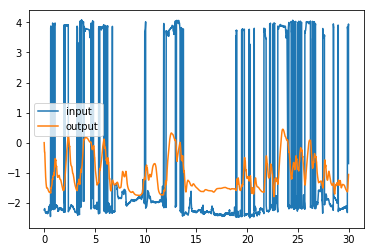

In [38]:
PatternInterpolationTrial().run(data_dir='debug')

In [4]:
for seed in range(5):
    for n_neurons in [200, 500, 1000, 2000, 5000]:
        PatternInterpolationTrial().run(seed=seed, n_neurons=n_neurons,
                                        data_dir='vary_neurons')


running PatternInterpolationTrial#20190125-111426-96e2a5ec


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 200
n_train_pattern = 3
mean_aimless = 0.41614883195915064
mean_goal = 0.5960254458093335
mean_noplay = -0.5911062647809721
median_aimless = 0.5525142546246806
median_goal = 0.6586628246352364
median_noplay = -0.7119565705436276
std_aimless = 0.44343006529305456
std_goal = 0.2997713543218168
std_noplay = 0.3667068695847472
running PatternInterpolationTrial#20190125-111451-ea687c03


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 500
n_train_pattern = 3
mean_aimless = 0.40917614998276003
mean_goal = 0.6488013686964647
mean_noplay = -0.8280422402419874
median_aimless = 0.5993719417292065
median_goal = 0.8347525079591975
median_noplay = -0.8834349648235034
std_aimless = 0.5082612662532217
std_goal = 0.405214423296493
std_noplay = 0.15336050038298477
running PatternInterpolationTrial#20190125-111518-29294172


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 1000
n_train_pattern = 3
mean_aimless = 0.4515459016753521
mean_goal = 0.7167401729238392
mean_noplay = -0.8539513296931546
median_aimless = 0.7378837268496574
median_goal = 0.8836192103678602
median_noplay = -0.904416913322702
std_aimless = 0.5544786898023745
std_goal = 0.41609526584704537
std_noplay = 0.15491175468025148
running PatternInterpolationTrial#20190125-111549-358c79be


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.460220389405419
mean_goal = 0.6225588955868507
mean_noplay = -0.8889508573627587
median_aimless = 0.708418919868492
median_goal = 0.7358117891451241
median_noplay = -0.9280441383732521
std_aimless = 0.6134325029076945
std_goal = 0.44668603067594476
std_noplay = 0.13019781738544148
running PatternInterpolationTrial#20190125-111627-92b8dfbd


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 5000
n_train_pattern = 3
mean_aimless = 0.49348152409813084
mean_goal = 0.9497720478831464
mean_noplay = -0.9007527822164143
median_aimless = 0.8493880289315373
median_goal = 0.9770990065665942
median_noplay = -0.9414182669281883
std_aimless = 0.6307597848085915
std_goal = 0.6082812503631015
std_noplay = 0.1374722898262475
running PatternInterpolationTrial#20190125-111753-5e47a636


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 200
n_train_pattern = 3
mean_aimless = 0.05609000774426562
mean_goal = 0.4888353481142792
mean_noplay = -0.4406520906071386
median_aimless = 0.32523789798831754
median_goal = 0.4641356335827377
median_noplay = -0.500323313398034
std_aimless = 0.7088358084273959
std_goal = 0.38794647111487685
std_noplay = 0.20554556737253016
running PatternInterpolationTrial#20190125-111821-c3f7dbfa


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 500
n_train_pattern = 3
mean_aimless = 0.14575980055391854
mean_goal = 0.5787071196612742
mean_noplay = -0.5078992684141136
median_aimless = 0.31958244953453063
median_goal = 0.5322319121486306
median_noplay = -0.6015065117073013
std_aimless = 0.8799396700556336
std_goal = 0.37151794610128863
std_noplay = 0.3050871841147865
running PatternInterpolationTrial#20190125-111851-a4bdc81f


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 1000
n_train_pattern = 3
mean_aimless = 0.21043806597380815
mean_goal = 0.6791771448197486
mean_noplay = -0.5264814540286827
median_aimless = 0.45884193916587185
median_goal = 0.7100464410811007
median_noplay = -0.6177270347116713
std_aimless = 0.9440981776243782
std_goal = 0.37547019481861477
std_noplay = 0.3592705130344385
running PatternInterpolationTrial#20190125-111928-7cc1e3aa


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.18108992014595532
mean_goal = 0.6893943955945293
mean_noplay = -0.5204016187600985
median_aimless = 0.43919459161124796
median_goal = 0.7129064119201365
median_noplay = -0.6250533530549608
std_aimless = 0.9052780494266625
std_goal = 0.3781017440273316
std_noplay = 0.3637580460093646
running PatternInterpolationTrial#20190125-112017-b2cd6fca


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 5000
n_train_pattern = 3
mean_aimless = 0.22732285380974002
mean_goal = 0.8202310714368436
mean_noplay = -0.5736667214176017
median_aimless = 0.3418471686230042
median_goal = 0.8853101007190167
median_noplay = -0.7081882761983456
std_aimless = 1.040603658810512
std_goal = 0.40055037077027644
std_noplay = 0.3979932030247722
running PatternInterpolationTrial#20190125-112227-cd866e64


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 200
n_train_pattern = 3
mean_aimless = 0.17964366760111714
mean_goal = 0.5619459014305951
mean_noplay = -0.7425375011028509
median_aimless = 0.17780258935830873
median_goal = 0.6055997148318922
median_noplay = -0.8658294366488235
std_aimless = 0.49162426787027935
std_goal = 0.23418776714223039
std_noplay = 0.36674737417261244
running PatternInterpolationTrial#20190125-112252-0b81621d


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 500
n_train_pattern = 3
mean_aimless = 0.21674644673940235
mean_goal = 0.6142515590302421
mean_noplay = -0.7595865994043399
median_aimless = 0.16787200620223028
median_goal = 0.6828677446969494
median_noplay = -0.8733597302655345
std_aimless = 0.4635460383765032
std_goal = 0.3280513007876833
std_noplay = 0.29182932600219713
running PatternInterpolationTrial#20190125-112319-37d068fd


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 1000
n_train_pattern = 3
mean_aimless = 0.09545198418332948
mean_goal = 0.6718203403029978
mean_noplay = -0.7932998142962994
median_aimless = -0.016282814984331706
median_goal = 0.7730049183931669
median_noplay = -0.8803313563425745
std_aimless = 0.583529859873021
std_goal = 0.36261739891358874
std_noplay = 0.21152289709084404
running PatternInterpolationTrial#20190125-112349-8fbcb395


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.26296141991418365
mean_goal = 0.6509151818007256
mean_noplay = -0.8557405734272193
median_aimless = 0.24115573859910627
median_goal = 0.699195682693371
median_noplay = -0.9896593771725657
std_aimless = 0.5199829381065734
std_goal = 0.3608394466576789
std_noplay = 0.28091168887222184
running PatternInterpolationTrial#20190125-112425-50cdcd04


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 5000
n_train_pattern = 3
mean_aimless = 0.37506788697051296
mean_goal = 0.7609398131050814
mean_noplay = -0.29745872883355895
median_aimless = 0.3912051078745853
median_goal = 0.8362302214721786
median_noplay = -0.5973690556480886
std_aimless = 0.603443445570258
std_goal = 0.42160620813875244
std_noplay = 0.5708883701584856
running PatternInterpolationTrial#20190125-112543-445c8878


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 200
n_train_pattern = 3
mean_aimless = 0.2719424159909757
mean_goal = 0.21891618704111154
mean_noplay = 0.19152895317571417
median_aimless = 0.3262517699606674
median_goal = 0.13267451952808412
median_noplay = 0.08654145732610108
std_aimless = 0.7870374020462888
std_goal = 0.4723107876694281
std_noplay = 0.3530574454422461
running PatternInterpolationTrial#20190125-112609-513cb43b


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 500
n_train_pattern = 3
mean_aimless = 0.23893346476836527
mean_goal = 0.1370256536001079
mean_noplay = 0.31015285850784574
median_aimless = 0.2941078017155216
median_goal = 0.09691689671630237
median_noplay = 0.27776276703621866
std_aimless = 0.8463821706463699
std_goal = 0.5810612596647117
std_noplay = 0.4128176756203053
running PatternInterpolationTrial#20190125-112636-63ea2d58


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 1000
n_train_pattern = 3
mean_aimless = 0.2721073785978623
mean_goal = 0.14874283272207184
mean_noplay = 0.4834033200813105
median_aimless = 0.4543941489181335
median_goal = 0.15185078079791975
median_noplay = 0.5051700378904403
std_aimless = 0.9114508732869238
std_goal = 0.6062440115245079
std_noplay = 0.4660375247482681
running PatternInterpolationTrial#20190125-112707-c6c19167


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.20924909671609457
mean_goal = 0.2955787848432028
mean_noplay = 0.4039494162267031
median_aimless = 0.4870329233310188
median_goal = 0.2613162777774558
median_noplay = 0.36596977892765425
std_aimless = 0.9100027378368221
std_goal = 0.5489910665561072
std_noplay = 0.43722859230644884
running PatternInterpolationTrial#20190125-112745-6a389ca7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 5000
n_train_pattern = 3
mean_aimless = 0.2055130731095075
mean_goal = 0.12769354401211602
mean_noplay = 0.30809197628346124
median_aimless = 0.5014786623561693
median_goal = 0.21324607095100678
median_noplay = 0.28421176612764976
std_aimless = 0.984691434405497
std_goal = 0.6836326872416679
std_noplay = 0.49071033671466247
running PatternInterpolationTrial#20190125-112902-03166a97


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 200
n_train_pattern = 3
mean_aimless = 0.035394248968412256
mean_goal = -0.03929740056450586
mean_noplay = -0.61476118574418
median_aimless = 0.011008153972420371
median_goal = -0.206964468874425
median_noplay = -0.6903433947561558
std_aimless = 0.6071255353312457
std_goal = 0.35645585689962606
std_noplay = 0.244305549415556
running PatternInterpolationTrial#20190125-112926-719d1539


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 500
n_train_pattern = 3
mean_aimless = 0.0067246300178346015
mean_goal = 0.08708924250872199
mean_noplay = -0.7733475747181144
median_aimless = 0.04014310649362217
median_goal = -0.15652909802830922
median_noplay = -0.8520160871822896
std_aimless = 0.7308016126293877
std_goal = 0.4994093458825696
std_noplay = 0.36024318788040016
running PatternInterpolationTrial#20190125-112949-b8cf1f93


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 1000
n_train_pattern = 3
mean_aimless = -0.02515918033225166
mean_goal = 0.15486806509463769
mean_noplay = -0.7640977080860084
median_aimless = 0.06426961119787024
median_goal = -0.00046992314912283915
median_noplay = -0.8557727162482064
std_aimless = 0.7341521113968555
std_goal = 0.4934055459634932
std_noplay = 0.3525248514875637
running PatternInterpolationTrial#20190125-113015-930cbc98


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.012248638781374015
mean_goal = 0.17304826383184135
mean_noplay = -0.7372502799435037
median_aimless = 0.029871479801825408
median_goal = -0.025234693665916914
median_noplay = -0.8005952383188847
std_aimless = 0.7573184218240602
std_goal = 0.5365695552038194
std_noplay = 0.3450511679997039
running PatternInterpolationTrial#20190125-113050-85cb36db


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 5000
n_train_pattern = 3
mean_aimless = 0.014887425272764765
mean_goal = 0.3234019212381076
mean_noplay = -0.6605750704993912
median_aimless = 0.049240965821930334
median_goal = 0.3378004682674556
median_noplay = -0.7383257281447553
std_aimless = 0.7116893790059897
std_goal = 0.49879092234749123
std_noplay = 0.33168112205344263


In [5]:
for seed in range(5):
    for n_train_pattern in [1,2,3,4,5]:
        PatternInterpolationTrial().run(seed = seed, data_dir='vary_train_pattern', 
                                        n_train_pattern = n_train_pattern)

running PatternInterpolationTrial#20190125-113154-04c09b89


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
n_train_pattern = 1
mean_aimless = -0.28784655345058363
mean_goal = 0.5654098830463692
mean_noplay = -0.8230774401586995
median_aimless = -0.46897513140118463
median_goal = 0.8644415631310891
median_noplay = -0.8391171271233933
std_aimless = 0.7911714531330479
std_goal = 0.8670384923490705
std_noplay = 0.3151384576751817
running PatternInterpolationTrial#20190125-113229-f8a65087


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
n_train_pattern = 2
mean_aimless = 0.6456866801009986
mean_goal = 1.1107168254585664
mean_noplay = -0.23998790563715672
median_aimless = 0.8934071675219506
median_goal = 1.013231657939236
median_noplay = -0.49689596649000056
std_aimless = 0.4730753000403842
std_goal = 0.6310582351175555
std_noplay = 0.5991770899201675
running PatternInterpolationTrial#20190125-113305-6a67e478


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.460220389405419
mean_goal = 0.6225588955868507
mean_noplay = -0.8889508573627587
median_aimless = 0.708418919868492
median_goal = 0.7358117891451241
median_noplay = -0.9280441383732521
std_aimless = 0.6134325029076945
std_goal = 0.44668603067594476
std_noplay = 0.13019781738544148
running PatternInterpolationTrial#20190125-113345-fb8cc3b5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
n_train_pattern = 4
mean_aimless = 0.31414437421212876
mean_goal = 0.03218575656375758
mean_noplay = 0.06568636875692653
median_aimless = 0.21261963960036803
median_goal = 0.01387238030882695
median_noplay = 0.010454237072743124
std_aimless = 0.44117274334112455
std_goal = 0.26814262398178457
std_noplay = 0.2882511233765061
running PatternInterpolationTrial#20190125-113428-68377072


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
n_train_pattern = 5
mean_aimless = 0.3809728913913101
mean_goal = 0.9412755463538744
mean_noplay = 0.30181454807076685
median_aimless = 0.5361822647882638
median_goal = 0.9413448292074882
median_noplay = 0.3184654099347325
std_aimless = 0.6263793659150535
std_goal = 0.4415915180170314
std_noplay = 0.4990128460766584
running PatternInterpolationTrial#20190125-113508-010447d9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
n_train_pattern = 1
mean_aimless = 0.44354761816503235
mean_goal = 0.08359868528666538
mean_noplay = 0.05643754138905501
median_aimless = 0.6306510871634214
median_goal = 0.14937589880150087
median_noplay = 0.234047795641453
std_aimless = 0.6586798220102789
std_goal = 0.7681255862181737
std_noplay = 0.5094074182339526
running PatternInterpolationTrial#20190125-113538-5a1b9602


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
n_train_pattern = 2
mean_aimless = 0.5062443573903364
mean_goal = 0.9572953864714806
mean_noplay = -0.8860682203643626
median_aimless = 0.6978545337369992
median_goal = 1.144321103876322
median_noplay = -0.9891638584417424
std_aimless = 0.9516122097984563
std_goal = 0.514034667580914
std_noplay = 0.2144028409242862
running PatternInterpolationTrial#20190125-113612-65fc8547


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.1810899201459554
mean_goal = 0.6893943955945293
mean_noplay = -0.5204016187600985
median_aimless = 0.4391945916112481
median_goal = 0.7129064119201365
median_noplay = -0.6250533530549608
std_aimless = 0.9052780494266625
std_goal = 0.3781017440273316
std_noplay = 0.3637580460093646
running PatternInterpolationTrial#20190125-113700-469f082c


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
n_train_pattern = 4
mean_aimless = 0.3810617830909605
mean_goal = 0.30019491490977407
mean_noplay = 0.1355497228969848
median_aimless = 0.2108907063908838
median_goal = 0.33134492778131974
median_noplay = 0.06511092079253122
std_aimless = 0.5437714778011501
std_goal = 0.4590177745393514
std_noplay = 0.24758882305039404
running PatternInterpolationTrial#20190125-113738-deef5676


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
n_train_pattern = 5
mean_aimless = 0.3367826495227604
mean_goal = -0.31309186342900297
mean_noplay = 0.23149565304188094
median_aimless = 0.37255245962386674
median_goal = -0.36146741982321634
median_noplay = 0.19083659255294325
std_aimless = 0.6309453208814457
std_goal = 0.5141248782298828
std_noplay = 0.47756243200968024
running PatternInterpolationTrial#20190125-113815-84d4d4dc


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 2000
n_train_pattern = 1
mean_aimless = 0.6386385084409367
mean_goal = 0.5231181491688167
mean_noplay = -0.5133380567324186
median_aimless = 0.5766794029797321
median_goal = 0.6175644035423509
median_noplay = -0.8471607388306358
std_aimless = 1.113776238894837
std_goal = 0.5727229430501176
std_noplay = 0.6096394693978405
running PatternInterpolationTrial#20190125-113850-66d8f500


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 2000
n_train_pattern = 2
mean_aimless = -0.10305638011447124
mean_goal = 0.5898962277368384
mean_noplay = -0.5436470396764325
median_aimless = 0.03034559956211797
median_goal = 0.6176267500512596
median_noplay = -0.7023762697977538
std_aimless = 0.6640394157772543
std_goal = 0.4227438591753659
std_noplay = 0.46417149333800384
running PatternInterpolationTrial#20190125-113926-91f5861a


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.26296141991418365
mean_goal = 0.6509151818007257
mean_noplay = -0.8557405734272193
median_aimless = 0.24115573859910638
median_goal = 0.699195682693371
median_noplay = -0.9896593771725658
std_aimless = 0.5199829381065734
std_goal = 0.36083944665767886
std_noplay = 0.28091168887222184
running PatternInterpolationTrial#20190125-114003-66868ed8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 2000
n_train_pattern = 4
mean_aimless = 0.34437761236132725
mean_goal = 0.1788444482193794
mean_noplay = -0.35994400770332685
median_aimless = 0.3567687342748952
median_goal = 0.020428863810872448
median_noplay = -0.23304310674726225
std_aimless = 0.4391517024698749
std_goal = 0.40034963610866997
std_noplay = 0.4837529265675895
running PatternInterpolationTrial#20190125-114046-784209b1


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 2000
n_train_pattern = 5
mean_aimless = 0.3037904879283615
mean_goal = -0.25519050086982525
mean_noplay = -0.6266028592917386
median_aimless = 0.3783820352973794
median_goal = -0.5230919973084385
median_noplay = -0.7491178035533265
std_aimless = 0.5720743012894831
std_goal = 0.675616233440512
std_noplay = 0.2569268437212356
running PatternInterpolationTrial#20190125-114124-0f6d3305


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 2000
n_train_pattern = 1
mean_aimless = 0.30627039281667856
mean_goal = 0.06739707473470276
mean_noplay = 0.10021997895464393
median_aimless = 0.4680983758555268
median_goal = 0.29635496976416886
median_noplay = 0.2071596667762362
std_aimless = 0.6765698021349311
std_goal = 0.8837072409850226
std_noplay = 0.5425368403963758
running PatternInterpolationTrial#20190125-114155-5241d9ed


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 2000
n_train_pattern = 2
mean_aimless = 0.37513908791726247
mean_goal = 0.8065761182576797
mean_noplay = -0.9977144029050233
median_aimless = 0.9288150605048193
median_goal = 0.9507825003434086
median_noplay = -0.990337969771
std_aimless = 0.9563464289748018
std_goal = 0.38574012728964513
std_noplay = 0.05733146446761076
running PatternInterpolationTrial#20190125-114229-8d9fd6aa


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.20924909671609457
mean_goal = 0.29557878484320277
mean_noplay = 0.40394941622670305
median_aimless = 0.4870329233310187
median_goal = 0.2613162777774558
median_noplay = 0.3659697789276542
std_aimless = 0.9100027378368221
std_goal = 0.5489910665561071
std_noplay = 0.43722859230644884
running PatternInterpolationTrial#20190125-114308-3b6dae53


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 2000
n_train_pattern = 4
mean_aimless = 0.12454207597104727
mean_goal = -0.032842252690603785
mean_noplay = 0.05422656816126588
median_aimless = 0.06365950074147844
median_goal = -0.1045379766208055
median_noplay = -0.03458603393138677
std_aimless = 0.7633115465006602
std_goal = 0.5131624816921219
std_noplay = 0.43600636508444884
running PatternInterpolationTrial#20190125-114344-ba44fdd5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 2000
n_train_pattern = 5
mean_aimless = 0.3645987803033571
mean_goal = -0.2675490598230829
mean_noplay = 0.1455986374743404
median_aimless = 0.6090825673241157
median_goal = -0.3394972614063405
median_noplay = 0.1350551876709432
std_aimless = 0.6446380193838961
std_goal = 0.5433645936020456
std_noplay = 0.4634076417034103
running PatternInterpolationTrial#20190125-114423-d1247e18


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 2000
n_train_pattern = 1
mean_aimless = 0.6367374849354289
mean_goal = 0.9088282873935584
mean_noplay = -0.8717095526891109
median_aimless = 0.7527059164449057
median_goal = 0.9453554245369489
median_noplay = -1.0226605870871102
std_aimless = 0.6958110181812682
std_goal = 0.28728186525045873
std_noplay = 0.28616959135419595
running PatternInterpolationTrial#20190125-114454-0c3c0387


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 2000
n_train_pattern = 2
mean_aimless = 0.750731102800957
mean_goal = 0.7449815494550572
mean_noplay = 0.4678237267619783
median_aimless = 0.9659953148989762
median_goal = 0.9863823703663376
median_noplay = 0.9086838165963
std_aimless = 0.5531897013528895
std_goal = 0.545522626994198
std_noplay = 0.9231640232640715
running PatternInterpolationTrial#20190125-114526-627c121a


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.012248638781374015
mean_goal = 0.17304826383184135
mean_noplay = -0.7372502799435037
median_aimless = 0.029871479801825408
median_goal = -0.025234693665916914
median_noplay = -0.8005952383188847
std_aimless = 0.7573184218240602
std_goal = 0.5365695552038194
std_noplay = 0.3450511679997039
running PatternInterpolationTrial#20190125-114558-81c2c44a


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 2000
n_train_pattern = 4
mean_aimless = 0.28475421938075746
mean_goal = -0.2632349968263858
mean_noplay = -0.09707261089239616
median_aimless = 0.26846743087227054
median_goal = -0.4050377216052851
median_noplay = -0.15352766513534766
std_aimless = 0.8635464057943922
std_goal = 0.577959280903408
std_noplay = 0.38748323496812287
running PatternInterpolationTrial#20190125-114632-6a635c42


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 2000
n_train_pattern = 5
mean_aimless = 0.36139742312445594
mean_goal = -0.3235858808470053
mean_noplay = -0.8190026495743346
median_aimless = 0.46401725701798
median_goal = -0.46467997013067824
median_noplay = -0.9230032941020239
std_aimless = 0.6121106941460003
std_goal = 0.5553464672495961
std_noplay = 0.35408778198195145


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

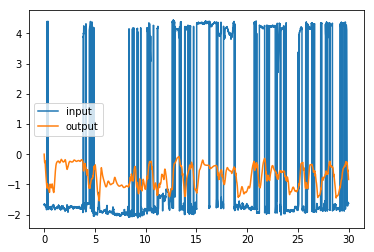

In [39]:
from sklearn.decomposition import PCA
data = pd.read_csv("pinsoro-2017-06-20-145454904791-small.csv", low_memory=False)
        
x = np.array(data.iloc[:,11:195]).astype(float)
a = []
for i in range(x.shape[1]):
    y = pd.Series(x[:,i])
    z = y.interpolate(limit_direction='both')
    a.append(z)
a = pd.DataFrame(a)
a = a.dropna()
a = np.array(a).T

dt = 0.001
        
def extract_pattern(start, end):
    pattern = np.array(a[start:end,:]).astype(float)
    frames = np.array(data.iloc[start:end,9]).astype(int)

    good_indices = frames != -1
    frames = frames[good_indices]
    pattern = pattern[good_indices]

    fps = 30.0
    t_sample = (frames - frames[0])/fps

    t = np.arange(int(t_sample[-1]/dt))*dt

    result = []
    for i in range(pattern.shape[1]):       
        p = np.interp(t, t_sample, pattern[:,i])
        result.append(p)
    result = np.array(result).T

    return t, result


t1, result1 = extract_pattern(374, 1790) #goaloriented
t2, result2 = extract_pattern(2642, 3446) #goaloriented
t3, result3 = extract_pattern(3867, 4637) #goaloriented
t4, result4 = extract_pattern(5976, 7491) #goaloriented
t5, result5 = extract_pattern(16968, 18323) #goaloriented
t6, result6 = extract_pattern(18569, 19200) #goaloriented
t7, result7 = extract_pattern(23672, 24737) #goaloriented 
t8, result8 = extract_pattern(24966, 26142) #goaloriented
t9, result9 = extract_pattern(26697, 26989) #goaloriented 
t10, result10 = extract_pattern(27100, 27156) #goaloriented
t11, result11 = extract_pattern(27212, 27983) #goaloriented
t12, result12 = extract_pattern(27984, 30898) #goaloriented
t13, result13 = extract_pattern(31201, 32875) #goaloriented
t14, result14 = extract_pattern(32876, 35231) #goaloriented
t15, result15 = extract_pattern(35232, 37106) #goaloriented
t16, result16 = extract_pattern(37278, 37637) #goaloriented
        
t17, result17 = extract_pattern(69, 373) #noplay
t18, result18 = extract_pattern(1943, 2036) #noplay
t19, result19 = extract_pattern(2195, 2344) #noplay
t20, result20 = extract_pattern(4638, 4727) #noplay
t21, result21 = extract_pattern(5162, 5396) #noplay
t22, result22 = extract_pattern(7492, 7532) #noplay
t23, result23 = extract_pattern(8257, 8350) #noplay
t24, result24 = extract_pattern(9974, 10133) #noplay
t25, result25 = extract_pattern(10523, 10592) #noplay
t26, result26 = extract_pattern(10835, 11160) #noplay
t27, result27 = extract_pattern(12128, 12369) #noplay
t28, result28 = extract_pattern(13653, 13852) #noplay
t29, result29 = extract_pattern(14210, 14272) #noplay
t30, result30 = extract_pattern(14374, 14422) #noplay
t31, result31 = extract_pattern(14485, 14648) #noplay
t32, result32 = extract_pattern(14755, 14811) #noplay
t33, result33 = extract_pattern(14973, 15459) #noplay
t34, result34 = extract_pattern(18324, 18451) #noplay
t35, result35 = extract_pattern(19201, 19262) #noplay
t36, result36 = extract_pattern(24738, 24965) #noplay
t37, result37 = extract_pattern(26143, 26696) #noplay
t38, result38 = extract_pattern(26990, 27099) #noplay
t39, result39 = extract_pattern(27157, 27211) #noplay
t40, result40 = extract_pattern(30899, 30979) #noplay
t41, result41 = extract_pattern(37107, 37277) #noplay
t42, result42 = extract_pattern(37638, 38416) #noplay

goal_list = [result1, result2, result3, result4, result5, result6, result7, result8, result9, 
                result10, result11, result12, result13, result14, result15, result16]
noplay_list = [result17, result18, result19, result20, result21, result22, result23, result24,
                result25, result26, result27, result28, result29, result30, result31, result32,
                result33, result34, result35, result36, result37, result38, result39, result40,
                result41, result42]
        
random.shuffle(goal_list)
goal_train = goal_list[:11]
goal_test = goal_list[11:]
        
random.shuffle(noplay_list)
noplay_train = noplay_list[:19]
noplay_test = noplay_list[19:]
        
train_all = np.vstack(goal_train+noplay_train)
pca_model = PCA(n_components=1).fit(train_all)

goal_patterns = {}
i=0
for p in goal_train:
    goal_patterns[i] = pca_model.transform(p)[:,0]
    i+=1

noplay_patterns = {}
for p in noplay_train:
    noplay_patterns[i] = pca_model.transform(p)[:,0]
    i+=1

patterns = {}
patterns.update(goal_patterns)
patterns.update(noplay_patterns)

goal_patterns = [(goal_patterns[key]) for key in goal_patterns.keys()]
noplay_patterns = [(noplay_patterns[key]) for key in noplay_patterns.keys()] 

theta = 1.0
net = nengo.Network()
with net:
    process = nengo.processes.WhiteSignal(period=100., high=1.0, y0=0)
    rw = nengolib.networks.RollingWindow(theta=theta, n_neurons=2000, process=process, neuron_type=nengo.LIFRate(tau_rc=0.02, tau_ref=0.002, amplitude=1))
            
s_window = int(theta/dt)
s_pattern = len(min(patterns.values(), key=len))


t_window = np.linspace(0, 1, s_window)
inv_basis = rw.inverse_basis(t_window)

eval_points=[]
target = []
for i in range(s_pattern):
    eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[0], i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[1], i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[2], i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[3], i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[4], i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[5], i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[6], i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[7], i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[8], i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[9], i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(goal_patterns[10], i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[0], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[1], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[2], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[3], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[4], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[5], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[6], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[7], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[8], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[9], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[10], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[11], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[12], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[13], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[14], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[15], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[16], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[17], i)[:s_window]))
    target.append([-1])
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns[18], i)[:s_window]))
    target.append([-1])

eval_points = np.array(eval_points)
        
with net:
    result = nengo.Node(None, size_in=1)
    nengo.Connection(rw.state, result,
                    eval_points=eval_points, scale_eval_points=True,
                    function=target, synapse=0.1)
    
    
#EXTRACT TEST PATTERNS
goal_test_patterns = {}
i=0
for p in goal_test:
    goal_test_patterns[i] = pca_model.transform(p)[:,0]
    i+=1

noplay_test_patterns = {}
for p in noplay_test:
    noplay_test_patterns[i] = pca_model.transform(p)[:,0]
    i+=1

patterns = {}
patterns.update(goal_test_patterns)
patterns.update(noplay_test_patterns)

goal_test_patterns = [(goal_test_patterns[key]) for key in goal_test_patterns.keys()]
noplay_test_patterns = [(noplay_test_patterns[key]) for key in noplay_test_patterns.keys()] 
test_all = np.hstack([noplay_test_patterns[0], goal_test_patterns[0], noplay_test_patterns[1], goal_test_patterns[1], noplay_test_patterns[2], goal_test_patterns[2], noplay_test_patterns[3], goal_test_patterns[3], noplay_test_patterns[4], goal_test_patterns[4], noplay_test_patterns[5], noplay_test_patterns[6]])

presentation_time_test=30/len(test_all)

model = nengo.Network()
model.networks.append(net)
with model:    
    stim = nengo.Node(nengo.processes.PresentInput(test_all, presentation_time=presentation_time_test))
    nengo.Connection(stim, rw.input, synapse=None)

    p_result = nengo.Probe(result)
    p_stim = nengo.Probe(stim)
sim = nengo.Simulator(model)
sim.run(30)

plt.plot(sim.trange(), sim.data[p_stim], label='input')
plt.plot(sim.trange(), sim.data[p_result], label='output')
plt.legend(loc='best')